<a href="https://colab.research.google.com/github/ethan-yoo/2022_aiffel_exp/blob/main/E05_RSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='slateblue'>**E05. 가위바위보 분류기 만들기 ✌️✊🖐</font>**

---

## **01. 데이터 가져오기**

- 훈련과 테스트에 쓸 데이터를 가져옵니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


✌️ 사용할 이미지 규격은 28*28이니 리사이징을 해줍니다.

In [ ]:
from PIL import Image
import glob
import os

# 리사이징 함수 생성
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 28x28 사이즈로 변환
	target_size=(28,28)
 
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

print('Done!')

Done!


In [ ]:
# 가위 리사이징
image_dir_path = "/content/drive/MyDrive/AIFFEL/E05/train_resized/scissor"
resize_images(image_dir_path)

print("resize Done!")

840  images to be resized.
840  images resized.
resize Done!


In [ ]:
# 바위 리사이징
image_dir_path = "/content/drive/MyDrive/AIFFEL/E05/train_resized/rock"
resize_images(image_dir_path)

print("resize Done!")

840  images to be resized.
840  images resized.
resize Done!


In [ ]:
# 보 리사이징
image_dir_path = "/content/drive/MyDrive/AIFFEL/E05/train_resized/paper"
resize_images(image_dir_path)

print("resize Done!")

840  images to be resized.
840  images resized.
resize Done!


✊ 잘 처리된 것 같습니다.

가위, 바위, 보 각 840개씩 총 2520개의 데이터네요!

---

## **02. 데이터 읽기 & 라벨링**

- 가위바위보는 총 3종류의 데이터를 가지고 있습니다.

- 따라서 데이터를 읽을 때 어떤 카테고리에 속하는지에 대한 정보를 주어야 합니다. (라벨링)

In [ ]:
import numpy as np

def load_data(img_path, number_of_data):  # 가위+바위+보

    # 라벨링 (가위:0, 바위:1, 보:2)
    img_size=28
    color=3

    # 이미지 데이터와 라벨(가위:0, 바위:1, 보:2) 데이터를 담을 행렬 영역을 생성
    imgs = np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels = np.zeros(number_of_data,dtype=np.int32)

    idx=0

    # 가위: 0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0
        idx=idx+1

    # 바위: 1
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1
        idx=idx+1  
    
    # 보: 2
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2
        idx=idx+1
        
    print("학습데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

print('Done!')

Done!


In [ ]:
# 정규화를 해줍니다.

image_dir_path = "/content/drive/MyDrive/AIFFEL/E05/train_resized"
(x_train, y_train)=load_data(image_dir_path, 2520)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))


학습데이터의 이미지 개수는 2520 입니다.
x_train shape: (2520, 28, 28, 3)
y_train shape: (2520,)


In [ ]:
# 정규화 결과 확인
print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))

최소값: 0.0  최대값: 1.0


🖐 잘 처리되었습니다. 한번 확인해볼까요?

라벨:  0


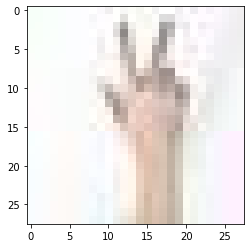

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

✌️ 첫 테스트 데이터는 가위인 것 같네요.

하지만 아직 학습을 하지 않았으니 모델은 이게 뭔지 모를 겁니다.

이제 딥러닝을 통해 이게 뭔지 가르쳐줘야 한다는 거죠!

---

## **03. 딥러닝 네트워크 설계하기**

- 일단 필요한 모듈부터 가져오겠습니다.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print('Done!')

Done!


✊ 흠, 어떤 네트워크를 써야 할까요?

일단 기본적인 LeNet을 사용해봅시다.

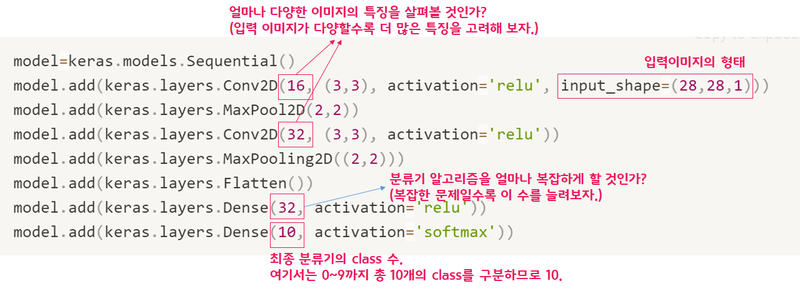

In [ ]:
# LeNet 네트워크 설계

channel_1 = 64
channel_2 = 128
dense = 32

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))


model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 5, 5, 128)        0         
 g2D)                                                            
                                                                 
 flatten_26 (Flatten)        (None, 3200)              0         
                                                                 
 dense_52 (Dense)            (None, 32)              

🖐 네트워크 모델을 설계했으니 이제 학습을 시켜봐야겠죠?

---

## **04. 모델 훈련 & 평가하기**

🖐 테스트용 데이터도 마찬가지로 리사이징과 정규화를 해줍니다.

In [ ]:
# 테스트 이미지 리사이징

# 가위
image_dir_path = "/content/drive/MyDrive/AIFFEL/E05/test_sh/scissor"
resize_images(image_dir_path)

# 바위
image_dir_path = "/content/drive/MyDrive/AIFFEL/E05/test_sh/rock"
resize_images(image_dir_path)

# 보
image_dir_path = "/content/drive/MyDrive/AIFFEL/E05/test_sh/paper"
resize_images(image_dir_path)


300  images to be resized.
300  images resized.
300  images to be resized.
300  images resized.
300  images to be resized.
300  images resized.


In [ ]:
image_dir_path = "/content/drive/MyDrive/AIFFEL/E05/test_sh"
(x_test, y_test)=load_data(image_dir_path, 900)
x_test_norm = x_test/255.0

학습데이터의 이미지 개수는 900 입니다.


In [ ]:
# 정규화 결과 확인
print('최소값:',np.min(x_test_norm), ' 최대값:',np.max(x_test_norm))

최소값: 0.0  최대값: 1.0


In [ ]:
# 학습을 시켜봅시다.
x_train_reshaped = x_train_norm.reshape(-1, 28, 28, 3)
x_test_reshaped = x_test_norm.reshape(-1, 28, 28, 3)


In [ ]:
# EarlyStopping 모듈을 사용합니다.
from tensorflow.keras.callbacks import EarlyStopping as es

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train_reshaped, y_train, epochs=30,
                    validation_split=0.1,
                    callbacks = [es(patience=5, monitor='val_loss')])

Epoch 1/30
71/71 [==============================] - 6s 79ms/step - loss: 0.7634 - accuracy: 0.6733 - val_loss: 1.6249 - val_accuracy: 0.2817
Epoch 2/30
71/71 [==============================] - 5s 74ms/step - loss: 0.1576 - accuracy: 0.9696 - val_loss: 0.2746 - val_accuracy: 0.8770
Epoch 3/30
71/71 [==============================] - 5s 75ms/step - loss: 0.0420 - accuracy: 0.9938 - val_loss: 0.5499 - val_accuracy: 0.7540
Epoch 4/30
71/71 [==============================] - 5s 74ms/step - loss: 0.0202 - accuracy: 0.9974 - val_loss: 0.3842 - val_accuracy: 0.8413
Epoch 5/30
71/71 [==============================] - 5s 75ms/step - loss: 0.0095 - accuracy: 0.9978 - val_loss: 0.1390 - val_accuracy: 0.9246
Epoch 6/30
71/71 [==============================] - 5s 75ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.2907 - val_accuracy: 0.8770
Epoch 7/30
71/71 [==============================] - 5s 73ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2969 - val_accuracy: 0.8770
Epoch 8/30
71

✌️ 음... loss와 accuracy 값이 날뛰는 군요.

한 번 어떻게 학습을 했는지 시각화를 해봅시다.

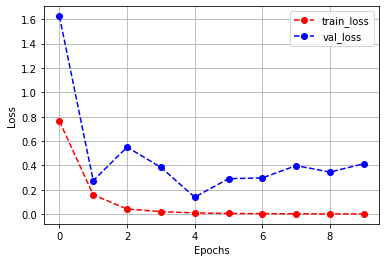

In [ ]:
# 시각화
plt.plot(history.history['loss'], '--o', color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], '--o', color = 'blue', label = 'val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

✊ 그럭저럭 무난하게 학습이 된 것 같습니다.

그래프를 보니 val_loss 값이 0.2~0.4 부근에서 왔다갔다 수렴하는 게 조금 아쉽습니다.

아무래도 train 데이터 숫자가 부족한 것 같지만, 일단 지금은 먼저 평가를 해 보겠습니다.

In [ ]:
# 평가하기

test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

29/29 - 1s - loss: 2.4892 - accuracy: 0.4789 - 518ms/epoch - 18ms/step
test_loss: 2.4891738891601562 
test_accuracy: 0.4788888990879059


🖐 정확도는 약 47.8%입니다.

맞냐 틀리냐 반반 무많이에서 무를 빼 버린 것 같은 애매한 수치네요.

---

## **Let's think...🤔🤔🤔**
- 원래 목표인 60%를 달성하려면 어떻게 해야 할까요?

> 1. train 데이터 추가
>
> 2. (추가적인) 데이터 전처리
>
> 3. 네트워크 파라미터 튜닝
>
> 4. 활성화 함수 변경
>
> 5. 다른 네트워크 모델 사용

정도를 생각해 볼 수 있겠네요.

하지만 그 전에 먼저 어디를 어떻게 틀리고 있는지 살펴봐야겠죠?

---

## **05. 어디를 어떻게 틀렸을까?**

In [ ]:
predicted_result = model.predict(x_test_reshaped)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=4  # 4번째 x_test
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [0.17402168 0.00225374 0.8237245 ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


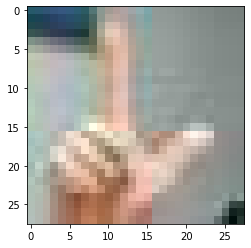

In [ ]:
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

✌️ 음... 이미지 일부가 잘려서 잘 못 알아봤던 걸까요?

다른 오답도 살펴봅시다.

model.predict() 결과 :  [0.16340332 0.00201874 0.8345779 ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


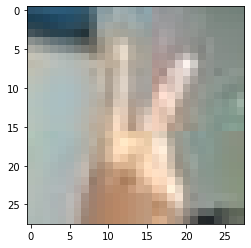

In [ ]:
predicted_result = model.predict(x_test_reshaped) 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=5
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

model.predict() 결과 :  [0.04957283 0.05207722 0.8983499 ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


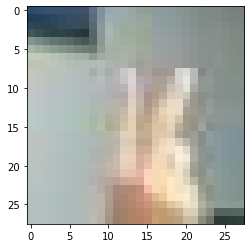

In [ ]:
predicted_result = model.predict(x_test_reshaped) 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=6
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

model.predict() 결과 :  [0.09884832 0.01639368 0.884758  ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


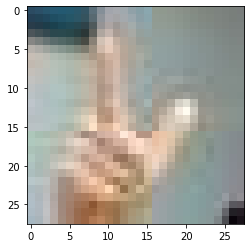

In [ ]:
predicted_result = model.predict(x_test_reshaped) 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=7
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

model.predict() 결과 :  [0.79115885 0.0014741  0.20736706]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


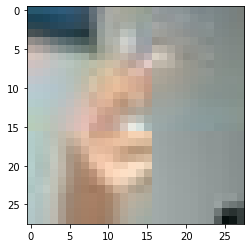

In [ ]:
predicted_result = model.predict(x_test_reshaped) 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=1
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

✊ 이건 정답을 맞혔네요.

오답들을 보니 아무래도 학습한 이미지에서 일부가 누락되면 (손목 부분이 없다거나) 잘 맞추지 못하는 것 같습니다.

혹시 가위 == 주먹 + 손가락 2개 정도로 인식하는 걸까요?

---

## **06. Data Augmentation**

- 문제에 대한 가설을 세웠으니 해결해 보겠습니다.

- 예상으로는 일부를 누락시킨 데이터를 추가로 생성해서 학습시키면 정확도가 오를 것 같네요.

> Keras Docs: https://keras.io/api/preprocessing/image/
>
> 이미지 증강: https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/

In [ ]:
# train_resized = train 데이터
# test_sh = test 데이터

# 모델 생성을 위한 모듈을 불러옵니다.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics


# train 데이터 처리
train_datagen = ImageDataGenerator(

                      rescale=1/255.,

                      # True면 50% 확률로 수평 뒤집기
                      horizontal_flip=True,

                      # 전체 크기의 10% 범위에서 상하좌우로 이동
                      width_shift_range=0.1,
                      height_shift_range=0.1,

                      fill_mode='nearest'
                       )


train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/AIFFEL/E05/train_resized',

                      target_size=(28, 28),
                      batch_size=5,
                      class_mode='sparse')

print('Done!')

Found 2520 images belonging to 3 classes.
Done!


In [ ]:
# 테스트 셋은 정규화만 진행

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/AIFFEL/E05/test_sh',
                                                  
                      target_size=(28, 28),
                      batch_size=5,
                      class_mode='sparse')

print('Done!')

Found 900 images belonging to 3 classes.
Done!


In [ ]:
# 모델 생성
# 네트워크 파라미터는 그대로 둡니다.

re_channel_1 = 64
re_channel_2 = 128
re_dense = 32

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(re_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(re_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(re_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.summary()


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 5, 5, 128)        0         
 g2D)                                                            
                                                                 
 flatten_35 (Flatten)        (None, 3200)              0         
                                                                 
 dense_70 (Dense)            (None, 32)              

In [ ]:
# 학습시켜 보겠습니다.
# EarlyStopping 모듈을 사용합니다.

history = model.fit_generator(train_generator,
                              
                              # 샘플 몇 개 뽑을지 결정
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=test_generator,
                              validation_steps=10,
                              callbacks = [es(patience=5, monitor='val_loss')])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


100/100 [==============================] - 3s 29ms/step - loss: 1.1095 - accuracy: 0.3300 - val_loss: 1.0975 - val_accuracy: 0.3400
Epoch 2/30
100/100 [==============================] - 3s 28ms/step - loss: 0.9410 - accuracy: 0.5600 - val_loss: 1.0854 - val_accuracy: 0.3000
Epoch 3/30
100/100 [==============================] - 3s 28ms/step - loss: 0.6162 - accuracy: 0.7280 - val_loss: 0.9748 - val_accuracy: 0.4400
Epoch 4/30
100/100 [==============================] - 3s 27ms/step - loss: 0.4590 - accuracy: 0.8300 - val_loss: 0.9896 - val_accuracy: 0.5200
Epoch 5/30
100/100 [==============================] - 3s 30ms/step - loss: 0.3726 - accuracy: 0.8660 - val_loss: 1.1117 - val_accuracy: 0.5200
Epoch 6/30
100/100 [==============================] - 3s 32ms/step - loss: 0.2891 - accuracy: 0.8880 - val_loss: 1.0541 - val_accuracy: 0.4800
Epoch 7/30
100/100 [==============================] - 3s 28ms/step - loss: 0.2238 - accuracy: 0.9260 - val_loss: 0.8321 - val_accuracy: 0.6000
Epoch 8/30

🖐 음... 여전히 loss 값과 accuracy 값이 들쭉날쭉 하군요.

일단 학습 과정을 살펴보겠습니다.

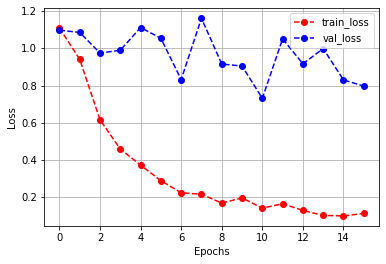

In [ ]:
# 시각화
plt.plot(history.history['loss'], '--o', color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], '--o', color = 'blue', label = 'val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

✌️ loss 값이 수렴하는 범위가 기존의 0.2\~0.4에서 0.8~1.0으로 더 높아졌네요.

아무래도 여러 노이즈가 있는 이미지를 학습하다보니 (= 학습 난이도가 올라가서) 편차가 커진 것 같습니다.

하지만 loss값과 prediction accuracy가 꼭 비례하는 것은 아니니 한 번 성능을 확인해 보겠습니다.

In [ ]:
# 평가하기

test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

29/29 - 1s - loss: 1.0069 - accuracy: 0.5633 - 1s/epoch - 40ms/step
test_loss: 1.0068601369857788 
test_accuracy: 0.5633333325386047


✊ 오, 예측 정확도가 47.8%에서 56.3%로 약 8.5% 향상되었습니다!

그럼 이번엔 어떤 이미지를 틀렸는지 살펴볼까요?

model.predict() 결과 :  [0.7762985  0.04209093 0.18161052]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


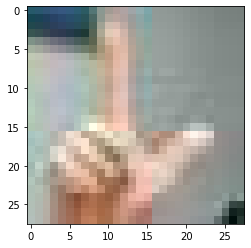

In [ ]:
predicted_result = model.predict(x_test_reshaped) 
predicted_labels = np.argmax(predicted_result, axis=1)

# 아까 틀렸던 이미지부터 살펴봅시다.

idx=4
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

model.predict() 결과 :  [0.8506766  0.03500588 0.11431744]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


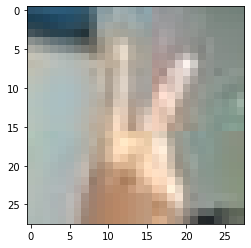

In [ ]:
predicted_result = model.predict(x_test_reshaped) 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=5
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

model.predict() 결과 :  [0.70953166 0.14209743 0.14837083]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


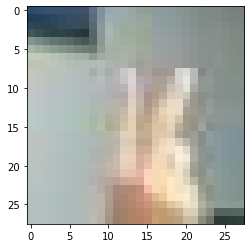

In [ ]:
predicted_result = model.predict(x_test_reshaped) 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=6
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

model.predict() 결과 :  [0.709505   0.06665687 0.2238381 ]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


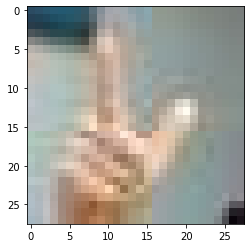

In [ ]:
predicted_result = model.predict(x_test_reshaped) 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=7
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

🖐 아까 틀렸던 이미지를 이번엔 잘 맞추었습니다.

아무래도 앞서 예상했던 "이미지 일부(손목 등)가 없으면 잘 못 맞춘다"는 가설이 맞았던 것 같죠?

model.predict() 결과 :  [0.31130746 0.08092412 0.6077685 ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


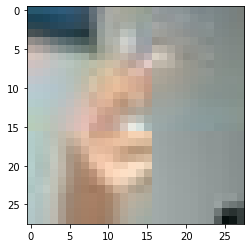

In [ ]:
predicted_result = model.predict(x_test_reshaped) 
predicted_labels = np.argmax(predicted_result, axis=1)

# 이번엔 아까 맞췄던 이미지를 살펴봅시다.

idx=1
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

✌️ 어라, 아까 맞춘 이미지는 다시 틀렸군요. 😢

---

## **Think again...🤔🤔🤔**

>1) 이미지의 일부가 잘려 있으면 잘 인식하지 못하니, 학습할 때부터 그런 이미지들을 만들어서 학습시키면 성능이 올라간다는 것은 확인했습니다.
>
>2) 그런데 이번에는 잘 인식하던 이미지를 인식하지 못하는 문제가 발생했습니다.
>
>3) 이미지와 잘못 예측한 값(가위->보)을 보건대, 이미지 증강 과정에서 'nearest' 옵션이 무언가 문제를 일으켰을 가능성도 있을 것 같습니다.
>
>4) 결과적으로 피쳐를 추출할 때 분류에 필요없는 특징을 잡았을 수도 있겠죠?

- **그렇다면 분류에 필요한 핵심 특징을 잡도록 해주면 될 것 같습니다.**

---

## **07. 핵심 Feature 잡기**

- 어떻게 하면 필요 없는 피쳐 대신 핵심적인 특징을 잡을 수 있을까요?

- 아마 네트워크 레이어 수와 채널을 수정하거나, 드롭아웃과 L1 규제 등을 써보는 것도 한 방법일 것 같습니다. 한 번 해보죠!

> **Ref.**
>
> 적은 데이터로 효율적인 학습하기 | https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/

---

### **07-1. 커널 크기 바꾸기**

- 커널 사이즈를 키우면 더 넓은 범위를 보게 되니까, 상대적으로 더 중요한 특징을 잡을 수 있지 않을까요?

In [ ]:
# 모델 생성

d_channel_1 = 64
d_channel_2 = 128
d_dense = 32
kernel_size = 5

model=Sequential()
model.add(Conv2D(d_channel_1, (kernel_size, kernel_size), activation='relu', input_shape=(28,28,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(d_channel_2, (kernel_size, kernel_size), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(d_dense, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 24, 24, 64)        4864      
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 4, 4, 128)        0         
 g2D)                                                            
                                                                 
 flatten_42 (Flatten)        (None, 2048)              0         
                                                                 
 dense_84 (Dense)            (None, 32)              

In [ ]:
# 학습시켜 보겠습니다.
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=test_generator,
                              validation_steps=10,
                              callbacks = [es(patience=5, monitor='val_loss')])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


100/100 [==============================] - 28s 34ms/step - loss: 1.0800 - accuracy: 0.4720 - val_loss: 1.1031 - val_accuracy: 0.4600
Epoch 2/30
100/100 [==============================] - 3s 32ms/step - loss: 0.7694 - accuracy: 0.6600 - val_loss: 1.1982 - val_accuracy: 0.3800
Epoch 3/30
100/100 [==============================] - 3s 31ms/step - loss: 0.4805 - accuracy: 0.8280 - val_loss: 0.8734 - val_accuracy: 0.5400
Epoch 4/30
100/100 [==============================] - 3s 32ms/step - loss: 0.3145 - accuracy: 0.8820 - val_loss: 0.9903 - val_accuracy: 0.4000
Epoch 5/30
100/100 [==============================] - 3s 32ms/step - loss: 0.2694 - accuracy: 0.9140 - val_loss: 1.0723 - val_accuracy: 0.5400
Epoch 6/30
100/100 [==============================] - 3s 31ms/step - loss: 0.1717 - accuracy: 0.9400 - val_loss: 0.9593 - val_accuracy: 0.5800
Epoch 7/30
100/100 [==============================] - 3s 32ms/step - loss: 0.1553 - accuracy: 0.9540 - val_loss: 0.7286 - val_accuracy: 0.6400
Epoch 8/3

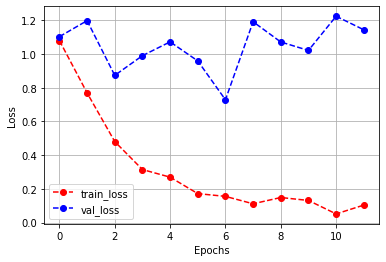

In [ ]:
# 시각화
plt.plot(history.history['loss'], '--o', color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], '--o', color = 'blue', label = 'val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

✊ 음, 커널 크기가 커지면 디테일하게 보기가 힘드니까 loss 값이 올라가는 것 같습니다.

일단 성능은 어떤지 테스트해 보겠습니다.

In [ ]:
# 평가하기

test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

29/29 - 1s - loss: 0.8910 - accuracy: 0.6256 - 774ms/epoch - 27ms/step
test_loss: 0.8910432457923889 
test_accuracy: 0.6255555748939514


🖐 56.3%에서 62.5%로 6.2% 가량 성능이 상승했습니다.

혹시 정확도 70%를 넘길 수도 있을까요?

---

### **07-2. Dropout 사용하기**

- 이번엔 드롭아웃을 통해 모델의 자체적인 성능 개선을 시도해 보겠습니다.


In [ ]:
# 모델 생성

d_channel_1 = 64
d_channel_2 = 128
d_dense = 32
kernel_size = 5

model=Sequential()
model.add(Conv2D(d_channel_1, (kernel_size, kernel_size), activation='relu', input_shape=(28,28,3)))
model.add(Dropout(0.2)) # 20% 드롭아웃 추가
model.add(MaxPooling2D(2,2))
model.add(Conv2D(d_channel_2, (kernel_size, kernel_size), activation='relu'))
model.add(Dropout(0.2)) # 20% 드롭아웃 추가
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(d_dense, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 24, 24, 64)        4864      
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 max_pooling2d_95 (MaxPoolin  (None, 4, 4, 128)        0         
 g2D)                                                

In [ ]:
# 학습
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=test_generator,
                              validation_steps=10,
                              callbacks = [es(patience=5, monitor='val_loss')])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


100/100 [==============================] - 4s 37ms/step - loss: 1.1159 - accuracy: 0.3180 - val_loss: 1.0959 - val_accuracy: 0.4200
Epoch 2/30
100/100 [==============================] - 3s 34ms/step - loss: 1.0330 - accuracy: 0.4420 - val_loss: 1.1234 - val_accuracy: 0.4400
Epoch 3/30
100/100 [==============================] - 3s 33ms/step - loss: 0.7971 - accuracy: 0.6400 - val_loss: 1.2663 - val_accuracy: 0.3400
Epoch 4/30
100/100 [==============================] - 3s 33ms/step - loss: 0.4797 - accuracy: 0.8560 - val_loss: 0.9477 - val_accuracy: 0.5200
Epoch 5/30
100/100 [==============================] - 3s 33ms/step - loss: 0.3336 - accuracy: 0.8780 - val_loss: 1.1341 - val_accuracy: 0.3800
Epoch 6/30
100/100 [==============================] - 3s 35ms/step - loss: 0.2285 - accuracy: 0.9180 - val_loss: 0.9854 - val_accuracy: 0.5000
Epoch 7/30
100/100 [==============================] - 3s 33ms/step - loss: 0.1711 - accuracy: 0.9360 - val_loss: 0.8774 - val_accuracy: 0.6200
Epoch 8/30

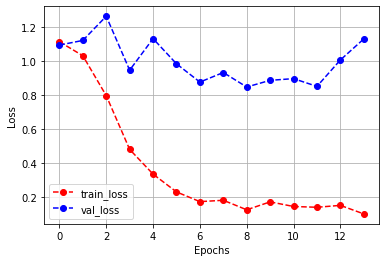

In [ ]:
# 시각화
plt.plot(history.history['loss'], '--o', color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], '--o', color = 'blue', label = 'val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

✌️ 오, loss 값이 줄어들었다는 건 난이도가 쉬워졌다(=모델의 성능이 좋아졌다)는 뜻으로 해석할 수도 있을 것 같습니다.

결과가 기대되는데, 빨리 평가해보죠!

In [ ]:
# 평가
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

29/29 - 1s - loss: 0.8468 - accuracy: 0.6600 - 776ms/epoch - 27ms/step
test_loss: 0.8467657566070557 
test_accuracy: 0.6600000262260437


✊ 야호! 정확도가 62.5% -> 66%로 약 3.5% 상승했습니다!

혹시 드롭아웃 비율을 더 높여주면 성능이 더 좋아질까요?

In [ ]:
# 모델 생성

d_channel_1 = 64
d_channel_2 = 128
d_dense = 32
kernel_size = 5

model=Sequential()
model.add(Conv2D(d_channel_1, (kernel_size, kernel_size), activation='relu', input_shape=(28,28,3)))
model.add(Dropout(0.4)) # 40% 드롭아웃 추가 / 비율을 2배로 늘려보겠습니다.
model.add(MaxPooling2D(2,2))
model.add(Conv2D(d_channel_2, (kernel_size, kernel_size), activation='relu'))
model.add(Dropout(0.4)) # 40% 드롭아웃 추가
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(d_dense, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 학습
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=test_generator,
                              validation_steps=10,
                              callbacks = [es(patience=5, monitor='val_loss')])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


100/100 [==============================] - 4s 35ms/step - loss: 1.1112 - accuracy: 0.3380 - val_loss: 1.0967 - val_accuracy: 0.3400
Epoch 2/30
100/100 [==============================] - 4s 35ms/step - loss: 1.0925 - accuracy: 0.4120 - val_loss: 1.1008 - val_accuracy: 0.4400
Epoch 3/30
100/100 [==============================] - 4s 36ms/step - loss: 1.0318 - accuracy: 0.5180 - val_loss: 1.2169 - val_accuracy: 0.2400
Epoch 4/30
100/100 [==============================] - 3s 34ms/step - loss: 0.9028 - accuracy: 0.5720 - val_loss: 1.1261 - val_accuracy: 0.2400
Epoch 5/30
100/100 [==============================] - 3s 33ms/step - loss: 0.5550 - accuracy: 0.7800 - val_loss: 1.0717 - val_accuracy: 0.4400
Epoch 6/30
100/100 [==============================] - 3s 33ms/step - loss: 0.3359 - accuracy: 0.8820 - val_loss: 0.8424 - val_accuracy: 0.6400
Epoch 7/30
100/100 [==============================] - 3s 34ms/step - loss: 0.3248 - accuracy: 0.8820 - val_loss: 0.9189 - val_accuracy: 0.6000
Epoch 8/30

🖐 이번에는 시각화와 평가까지 동시에 진행하겠습니다.

29/29 - 1s - loss: 0.9083 - accuracy: 0.6178 - 784ms/epoch - 27ms/step
test_loss: 0.9082571864128113 
test_accuracy: 0.6177777647972107


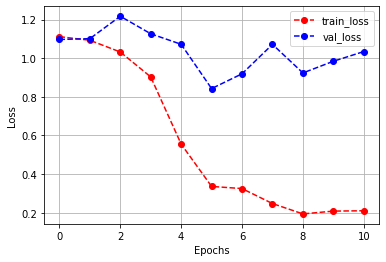

In [ ]:
# 시각화
plt.plot(history.history['loss'], '--o', color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], '--o', color = 'blue', label = 'val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# 평가
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

✌️ 음, random seed에 따른 변화까지 고려하면 큰 차이는 안 나는 것 같습니다.

---

### **07-3. L1 Regulation 사용해보기**

- 기존 목표였던 60%는 달성했지만, 66% 정확도를 봤으니 70%도 넘겨보고 싶습니다.

- L1 규제는 과적합을 방지하는 동시에 필요한 피쳐만 추출하는 효과가 있다고 하네요. 한 번 어느 정도 효과가 있는지 살펴보겠습니다.

> **Ref.**
>
> L1, L2 규제에 관해 | https://blog.naver.com/sjy5448/222616963236

In [ ]:
# 모델 생성

d_channel_1 = 64
d_channel_2 = 128
d_dense = 32
kernel_size = 5

model=Sequential()
model.add(Conv2D(d_channel_1, (kernel_size, kernel_size), activation='relu', input_shape=(28,28,3)))
model.add(Dropout(0.2)) # 20% 드롭아웃 추가 
model.add(MaxPooling2D(2,2))
model.add(Conv2D(d_channel_2, (kernel_size, kernel_size), activation='relu'))
model.add(Dropout(0.2)) # 20% 드롭아웃 추가
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(d_dense, activation='relu', kernel_regularizer='l1')) # L1 regulation 추가
model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


# 학습
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=test_generator,
                              validation_steps=10,
                              callbacks = [es(patience=5, monitor='val_loss')])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


100/100 [==============================] - 4s 35ms/step - loss: 5.0488 - accuracy: 0.3480 - val_loss: 1.2165 - val_accuracy: 0.3200
Epoch 2/30
100/100 [==============================] - 3s 34ms/step - loss: 1.1834 - accuracy: 0.3160 - val_loss: 1.1766 - val_accuracy: 0.3400
Epoch 3/30
100/100 [==============================] - 3s 33ms/step - loss: 1.1776 - accuracy: 0.3040 - val_loss: 1.1772 - val_accuracy: 0.3200
Epoch 4/30
100/100 [==============================] - 3s 34ms/step - loss: 1.1777 - accuracy: 0.3040 - val_loss: 1.1776 - val_accuracy: 0.3200
Epoch 5/30
100/100 [==============================] - 3s 34ms/step - loss: 1.1778 - accuracy: 0.3100 - val_loss: 1.1777 - val_accuracy: 0.2800
Epoch 6/30
100/100 [==============================] - 4s 35ms/step - loss: 1.1777 - accuracy: 0.3380 - val_loss: 1.1766 - val_accuracy: 0.3800
Epoch 7/30
100/100 [==============================] - 3s 34ms/step - loss: 1.1773 - accuracy: 0.3600 - val_loss: 1.1775 - val_accuracy: 0.3200


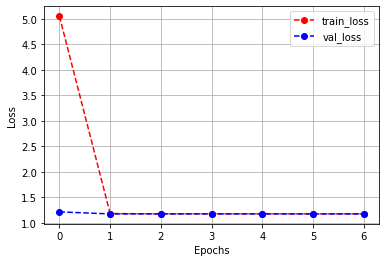

In [ ]:
# 시각화
plt.plot(history.history['loss'], '--o', color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], '--o', color = 'blue', label = 'val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [ ]:
# 평가
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

29/29 - 1s - loss: 1.1773 - accuracy: 0.3333 - 823ms/epoch - 28ms/step
test_loss: 1.1773000955581665 
test_accuracy: 0.3333333432674408


✊ 예상과 달리 정확도가 반절 가까이 폭삭 주저앉아 버렸습니다.

L2 규제는 어떨까요?

---

### **07-4. L2 Regulation**

In [ ]:
# 모델 생성

d_channel_1 = 64
d_channel_2 = 128
d_dense = 32
kernel_size = 5

model=Sequential()
model.add(Conv2D(d_channel_1, (kernel_size, kernel_size), activation='relu', input_shape=(28,28,3)))
model.add(Dropout(0.2)) # 20% 드롭아웃 추가 
model.add(MaxPooling2D(2,2))
model.add(Conv2D(d_channel_2, (kernel_size, kernel_size), activation='relu'))
model.add(Dropout(0.2)) # 20% 드롭아웃 추가
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(d_dense, activation='relu', kernel_regularizer='l2')) # L2 regulation 추가
model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


# 학습
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=test_generator,
                              validation_steps=10,
                              callbacks = [es(patience=5, monitor='val_loss')])



Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


100/100 [==============================] - 6s 46ms/step - loss: 1.3350 - accuracy: 0.3580 - val_loss: 1.2015 - val_accuracy: 0.4000
Epoch 2/30
100/100 [==============================] - 4s 36ms/step - loss: 0.9102 - accuracy: 0.6260 - val_loss: 1.2418 - val_accuracy: 0.3400
Epoch 3/30
100/100 [==============================] - 4s 36ms/step - loss: 0.6219 - accuracy: 0.7660 - val_loss: 1.0574 - val_accuracy: 0.4800
Epoch 4/30
100/100 [==============================] - 4s 35ms/step - loss: 0.4236 - accuracy: 0.8600 - val_loss: 1.0650 - val_accuracy: 0.4200
Epoch 5/30
100/100 [==============================] - 3s 35ms/step - loss: 0.2670 - accuracy: 0.9360 - val_loss: 1.0873 - val_accuracy: 0.4400
Epoch 6/30
100/100 [==============================] - 3s 34ms/step - loss: 0.2345 - accuracy: 0.9320 - val_loss: 0.9745 - val_accuracy: 0.4600
Epoch 7/30
100/100 [==============================] - 3s 34ms/step - loss: 0.3144 - accuracy: 0.9220 - val_loss: 0.9156 - val_accuracy: 0.7000
Epoch 8/30

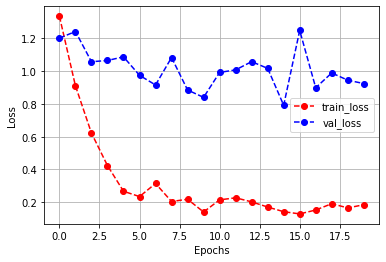

In [ ]:
# 시각화
plt.plot(history.history['loss'], '--o', color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], '--o', color = 'blue', label = 'val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [ ]:
# 평가
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

29/29 - 1s - loss: 0.7364 - accuracy: 0.7178 - 1s/epoch - 42ms/step
test_loss: 0.736352264881134 
test_accuracy: 0.7177777886390686


🖐 드디어 70%가 넘는 정확도가 나왔습니다. **목표 달성!**

---

# **회고**

> 아직 L1, L2 Regulation의 작동 원리를 잘 이해하지 못했습니다. 😢
>
> 그래서 원래 L2 규제는 sparse problem에 쓰는 게 아니라거나, L1 규제를 통해서 핵심 피쳐만 추출할 수 있다는 내용이 왜 이번에는 적용되지 않았는지 이유를 모르겠습니다.
>
> 또, 최종적으로 추출된 71%의 정확도는 random seed 값을 고정해놓지 않아서 재현성이 매우 떨어진다는 단점이 있습니다.
>
> 코딩 실력의 한계로(....) Stratified K-Fold를 통해 신뢰할 만한 정확도를 구하지 못했는데 이 부분은 나중에 여유가 있을 때 다시 도전해 보겠습니다.